# Using a Variational Auto-encoder to predict protein fitness from evolutionary data

July 20, 2017
### Sam Sinai and Eric Kelsic


## For the blog post associated with this notebook see [this post](https://samsinai.github.io/jekyll/update/2017/08/14/Using-a-Variational-Autoencoder-to-predict-protein-function.html). 


This notebook it organized in 3 sections. In section 1 we show our workflow for pre-processing the biological data. We then train the model on the alignment data in section 2. In section 3 we compare the predictions of the model on the [PABP yeast](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3851721/) dataset. In section 4 we report the results from analyzing multiple other datasets. Finally we pose some questions with regards to improving the model for interested researcher.

In [855]:
# Generic imports
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
import math, random, re
import time

In [856]:
#Machine learning/Stats imports 
from scipy.stats import norm
from scipy.stats import spearmanr,pearsonr
from sklearn.preprocessing import normalize
import tensorflow as tf
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import LSTM, RepeatVector
from keras.layers import Input, Dense, Lambda, Dropout,Activation, TimeDistributed
from keras import backend as K
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras import regularizers

## 1.  Data pre-processing

Defining the alphabet that is used for Amino-Acids throughout.

In [857]:
# A2M reference:
# https://compbio.soe.ucsc.edu/a2m-desc.html
# Amino acid alphabet:
AAamb_ORDER = 'ABCDEFGHIKLMNPQRSTVWXYZ-'
AAamb_LIST = list(AAamb_ORDER)
AAamb_DICT = {c:i for i, c in enumerate(AAamb_LIST)}
AAamb_SET = set(AAamb_LIST)
AA_ORDER = 'ACDEFGHIKLMNPQRSTVWY-'
AA_LIST = list(AA_ORDER)
AA_DICT = {c:i for i, c in enumerate(AA_LIST)}
AA_SET = set(AA_LIST)

These are helper functions to clean and process data. 

In [858]:
%load_ext autoreload
%autoreload 2
from helper_tools import *
from helper_tools_for_plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [859]:
# Dataset definitions:
dataset_name = 'PABP_YEAST'
trainset_file = 'PABP_YEAST_hmmerbit_plmc_n5_m30_f50_t0.2_r115-210_id100_b48.a2m'
trainset_format = 'a2m'
trainset_weights = 'PABP_YEAST_trainset_weights.p'
testset_file = 'PABP_YEAST_Fields2013-all.csv'
testset_format = 'mut_code'
wt_seq = 'KGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATDENGKSKGFGFVHFEEEGAAKEAIDALNGMLLNGQEIYVAPHLSR'
OFFSET = 123

In [860]:
# Initialize the object:
vae_data = VAEdata('PABP_YEAST')
# Initialize minimum observation frequency in each alignment column:
vae_data.obs_cutoff(min_freq=0.05)
# Read training set:
vae_data.read_train_set(trainset_file, fformat=trainset_format)
# Reweight the sequences:
vae_data.reweight_sequences(cached_file=trainset_weights)  # takes ~7 hours for 150,000 sequences
# vae_data.get_ordered_weights()
# Read test set:
vae_data.read_test_set(filename=testset_file, fformat=testset_format, wt_seq=wt_seq, offset=OFFSET)
# Calculate batch size:
vae_data.calc_batch_size(batch_size_train_cut=1000, batch_size_test_cut=1000, batch_size_try=[100, 50, 10])

Loaded weights from filename: PABP_YEAST_trainset_weights.p
Header was encountered:
mutant;effect_prediction_epistatic;effect_prediction_independent;linear
Mutation key is grabbed from this column: "mutant"
Effect is grabbed from this column: "linear"
Showing the possible values (at most 100 is printed):
batch_size   train_cut   test_cut
       100         528        710
        50          28        210
        10          28         10
Using the first as default:
batch_size 100
train_cut 528
test_cut 710


In [861]:
# Manually edit batch size:
vae_data.batch_size = 50
vae_data.train_cut = 28
vae_data.test_cut = 210

This concludes the pre-processing we need to do on the data.

## 2.  Training the model
We now move on to define our neural network. This is essentially a vanilla VAE in keras (with some optimization on hyperparameters). For optimization purposes we define a callback function that reports the predictive power of the model in the end of each epoch. Note that while this passes the -test data- through the model, it is kosher because we never pass in the values we are actually interested in and the network is not in "training phase", i.e. no weights are updated during this pass. 

In [862]:
class Test_Corr(keras.callbacks.Callback):
    def __init__(self, x, t, batch_size, AA_numb, seq_len):
        assert(len(x) == len(t))
        self.x = x
        self.t = t
        self.batch_size = batch_size
        self.AA_numb = AA_numb
        self.seq_len = seq_len
        self.scores = []
        self.count_batch = 0
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
    def on_epoch_end(self, batch, logs):
        '''Track the progress of the model on different epochs.'''
        x_decoded = vae.predict(self.x, batch_size=self.batch_size)
        loglik = compute_loglik(onehot_seqs=self.x, pwms=x_decoded, AA_numb=self.AA_numb, seq_len=self.seq_len)
        corr = spearmanr(loglik, self.t)
        print(',' + str(corr))
        self.scores.append(corr[0])

Now we are ready to specify the network architecture, this is adapted from [here](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py).

In [876]:
batch_size = vae_data.batch_size
input_dim = len(AA_ORDER) * vae_data.get_seq_len()
output_dim = input_dim  # This true per-definition in a VAE
latent_dim = 2
encoder_architecture = [10, 10]
decoder_architecture = [10, 10]
nb_epoch = 50
epsilon_std = 1.0
np.random.seed(42)  

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=epsilon_std)
    return(z_mean + K.exp(z_log_var / 2) * epsilon)

def vae_loss(x, x_decoded_mean):
    xent_loss = input_dim * objectives.categorical_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return(xent_loss + kl_loss)

# Encoding layers:
x = Input(batch_shape=(batch_size, input_dim))
for layer_num, hidden_units in enumerate(encoder_architecture):
    if layer_num == 0:
        h = Dense(hidden_units, activation="sigmoid")(x)
    else:
        h = Dense(hidden_units, activation="elu")(h)
    h = BatchNormalization()(h)

# Latent layers:
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_log_var])

# Decoding layers:
decoder_1 = Dense(decoder_architecture[0], activation='elu')
decoder_2 = Dense(decoder_architecture[1], activation='elu')
decoder_out = Dense(output_dim, activation='sigmoid')
x_decoded_mean = decoder_out(decoder_2(decoder_1(z)))

vae = Model(x, x_decoded_mean)
vae.compile(optimizer="adam", loss=vae_loss) #, metrics=["categorical_accuracy", "top_k_categorical_accuracy"])

And run it through our training data.

In [ ]:
x_train = vae_data.train_onehot_list[:-vae_data.train_cut][:]
x_test = vae_data.test_onehot_list[:-vae_data.test_cut][:]
test_value_list = vae_data.test_value_list[:-vae_data.test_cut]

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
spearman_corr = Test_Corr(x_test, test_value_list, batch_size, len(AA_ORDER), vae_data.get_seq_len())

hist = vae.fit(x_train,
               x_train,
               shuffle=True,
               epochs=nb_epoch,
               batch_size=batch_size,
               sample_weight=vae_data.train_ordered_weights[:-vae_data.train_cut],
               validation_split=0.1,
               callbacks=[early_stopping, spearman_corr])

Train on 136350 samples, validate on 15150 samples
Epoch 1/50
136350/136350 [==============================] - 47s - loss: 102650.4303 - val_loss: 191687.4209
Epoch 2/50
127950/136350 [===========================>..] - ETA: 1s - loss: 100056.1543

In [ ]:
encoder = Model(x, z_mean)

In [ ]:
# Have to add some junk to make it passing through the network b/c of the batch size:
x_wt_seq_plus = np.vstack((vae_data.wt_seq_onehot_list, vae_data.test_onehot_list[:(vae_data.batch_size-1)][:]))
x_wt_seq_decoded = vae.predict(x_wt_seq_plus, batch_size=vae_data.batch_size)
x_wt_seq = [x_wt_seq_plus[0]]
x_wt_seq_decoded = [x_wt_seq_decoded[0]]
loglik = compute_loglik(onehot_seqs=x_wt_seq, pwms=x_wt_seq_decoded, AA_numb=len(AA_ORDER), seq_len=vae_data.get_seq_len())
vae_data.add_loglik(loglik=loglik, itype='wt_seq')
x_wt_seq_encoded = encoder.predict(x_wt_seq_plus, batch_size=vae_data.batch_size)
x_wt_seq_encoded = np.array([x_wt_seq_encoded[0]])
vae_data.add_latent(latent=x_wt_seq_encoded, itype='wt_seq')

In [ ]:
x_test = vae_data.test_onehot_list[:-vae_data.test_cut][:]
x_test_decoded = vae.predict(x_test, batch_size=vae_data.batch_size)
loglik = compute_loglik(onehot_seqs=x_test, pwms=x_test_decoded, AA_numb=len(AA_ORDER), seq_len=vae_data.get_seq_len())
vae_data.add_loglik(loglik=loglik, itype='test')
x_test_encoded = encoder.predict(x_test, batch_size=vae_data.batch_size)
vae_data.add_latent(latent=x_test_encoded, itype='test')

In [ ]:
x_train = vae_data.train_onehot_list[:-vae_data.train_cut][:]
x_train_decoded = vae.predict(x_train, batch_size=vae_data.batch_size)
loglik = compute_loglik(onehot_seqs=x_train, pwms=x_train_decoded, AA_numb=len(AA_ORDER), seq_len=vae_data.get_seq_len())
vae_data.add_loglik(loglik=loglik, itype='train')
x_train_encoded = encoder.predict(x_train, batch_size=vae_data.batch_size)
vae_data.add_latent(latent=x_train_encoded, itype='train')

We have kept track of some performance metrics, so we can follow whether the network was still improving. 

In [ ]:
# Print performance measures over time:
# keys = ['categorical_accuracy', 'top_k_categorical_accuracy']
keys = ['val_loss']  # Look at the loss function, on the validation data
for key in keys:
    plt.plot(hist.history[key], label=key)
plt.xlabel('epoch')
plt.legend(bbox_to_anchor=(1.6, 0.5));

Our metric of interest of course is the prediction power (here spearman's rank correlation) between protein sequence probability and the actual fitness measurements.

In [ ]:
plt.plot(spearman_corr.scores)
plt.title("Spearman corr over epochs")
plt.xlabel("epoch")
plt.ylabel("Spearman corr");

In [869]:
N_test = 1000
N_train = 10000

a = np.arange(len(vae_data.test_latent))
choices = set(list(np.random.choice(a, size=N_test, replace=False)))
sele_test = np.array([True if i in choices else False for i in a])

a = np.arange(len(vae_data.train_latent))
choices = set(list(np.random.choice(a, size=N_train, replace=False)))
sele_train = np.array([True if i in choices else False for i in a])

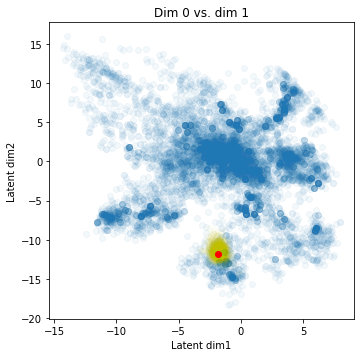

In [872]:
fig = plt.figure(figsize=(12,12))
counter = 0
for z1 in range(latent_dim):
    for z2 in range(z1+1, latent_dim):
        counter += 1
        fig.add_subplot(latent_dim,latent_dim, counter)
        plt.title('Dim {} vs. dim {}'.format(str(z1), str(z2)))
        plt.scatter(vae_data.train_latent[sele_train, z1], vae_data.train_latent[sele_train, z2], alpha=0.05)
        plt.scatter(vae_data.test_latent[sele_test, z1], vae_data.test_latent[sele_test, z2], c='y', alpha=0.03)
        plt.scatter(vae_data.wt_seq_latent[z1], vae_data.wt_seq_latent[z2], c='r', alpha=1)
        plt.xlabel('Latent dim' + str(z1+1))
        plt.ylabel('Latent dim' + str(z2+1));

In [873]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=1).fit(x_train[sele_train, :])

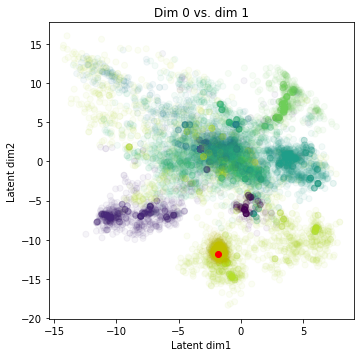

In [874]:
fig = plt.figure(figsize=(12,12))
counter = 0
cmap = kmeans.labels_
for z1 in range(latent_dim):
    for z2 in range(z1+1, latent_dim):
        counter += 1
        fig.add_subplot(latent_dim,latent_dim, counter)
        plt.title('Dim {} vs. dim {}'.format(str(z1), str(z2)))
        plt.scatter(vae_data.train_latent[sele_train, z1], vae_data.train_latent[sele_train, z2], c=cmap, alpha=0.05)
        plt.scatter(vae_data.test_latent[sele_test, z1], vae_data.test_latent[sele_test, z2], c='y', alpha=0.03)
        plt.scatter(vae_data.wt_seq_latent[z1], vae_data.wt_seq_latent[z2], c='r', alpha=1)
        plt.xlabel('Latent dim' + str(z1+1))
        plt.ylabel('Latent dim' + str(z2+1));

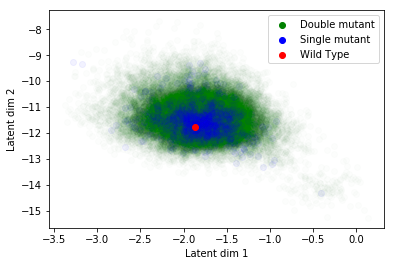

In [875]:
Nmut_label = np.array([len(vae_data.test_seq_dict_order[i]) for i in range(len(vae_data.test_latent))])
sele_1 = np.array([True if i == 1 else False for i in Nmut_label])
sele_2 = np.array([True if i == 2 else False for i in Nmut_label])

plt.scatter(vae_data.test_latent[sele_2, 0], vae_data.test_latent[sele_2, 1], c='g', alpha=0.01, label='Double mutant')
plt.scatter(vae_data.test_latent[sele_1, 0], vae_data.test_latent[sele_1, 1], c='b', alpha=0.05, label='Single mutant')
plt.scatter(vae_data.wt_seq_latent[0], vae_data.wt_seq_latent[1], c='r', alpha=1, label='Wild Type')

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2');

<a id='P_compute'></a>


## 4. Predicting fitness based on sequence probability

We compute the (log) probability of a sequence as:
$$ \log(trace(H^T P)) $$

Where $H$ is the one-hot encoding of the sequence of interest, and $P$ is the probability weight matrix generated by feeding the network a sequence. Taking the trace of the matrix product is similar to the dot product of two vectors. We compute the fitness in three highly correlated ways (although depending on the dataset, these correlations change). The difference in these approaches is in how to compute $P$. 

(1)$P$ is the reconstruction of the same sequence that $H$ represents. (we call this prediction or "fitness" in the code)

(2) $P$ is the reconstruction of the wildtype sequence.  (we call this prediction_wt or "fitness_wt" in the code)

(3) $P$ is an average reconstruction of 100 samples of mutants. (we call this prediction_avg or "fitness_avg" in the code)

### 4.1. Single mutants

We can now use the trained network to predict the fitnesses. The first step is to compute the fitnesses for all single mutant sequences (and compare it to the wildtype). 

In [63]:
sample_size=batch_size*int(len(test_data_plus)/batch_size)
sample_for_averging_size=100
sequence_size = vae_data.get_seq_len()
digit_size = len(AA_ORDER)
x_decoded=vae.predict(test_data_plus[0:sample_size],batch_size=batch_size)

digit = x_decoded[0].reshape(digit_size,sequence_size)
digit_wt = normalize(digit,axis=0, norm='l1')
wt_prob=compute_log_probability(test_data_plus[0].reshape(digit_size,sequence_size),digit_wt)
#print ("wt_log_prob: ", wt_prob)

wt_probs=[]
digit_avg=np.zeros((digit_size,sequence_size))


sample_indices=random.sample(range(sample_size),sample_for_averging_size)

counter=0
for sample in sample_indices:
    digit = x_decoded[sample].reshape(digit_size,sequence_size)
    digit_wt_i = normalize(digit,axis=0, norm='l1')
    
    digit_avg+=digit_wt_i*1./sample_for_averging_size
    wt_p=compute_log_probability(test_data_plus[sample].reshape(digit_size,sequence_size),digit_wt_i)
    wt_probs.append(wt_p)
    counter+=1
average_wt_p=np.mean(wt_probs)

fitnesses_vs_wt=[]
fitnesses=[]
fitnesses_vs_avg=[]

for sample in range(1,sample_size):
    digit = x_decoded[sample].reshape(digit_size,sequence_size)
    digit = normalize(digit,axis=0, norm='l1')
    fitness=compute_log_probability(test_data_plus[sample].reshape(digit_size,sequence_size),digit)-wt_prob
    fitnesses.append(fitness)
    
    fitness=compute_log_probability(test_data_plus[sample].reshape(digit_size,sequence_size),digit_wt)-wt_prob
    fitnesses_vs_wt.append(fitness)
    
    fitness=compute_log_probability(test_data_plus[sample].reshape(digit_size,sequence_size),digit_avg)-average_wt_p
    fitnesses_vs_avg.append(fitness)
    
    
print ("Spearman",spearmanr(fitnesses,target_values_singles[:sample_size-1]))
print ("Pearson", pearsonr(fitnesses,target_values_singles[:sample_size-1]))

Spearman SpearmanrResult(correlation=0.64076564403665581, pvalue=2.8444825586652738e-137)
Pearson (0.6157237078492831, 5.7977976195997752e-124)


As a first step, we draw the distribution of the normalized predicted fitnesses vs. the experimental data. We care about the relative distributions, rather than the exact values, so we can renormalize the predictions to roughly fall in the range of the data.

In [64]:
predictions=np.array(list(map(lambda x: x*1./(4*(max (fitnesses))),fitnesses))) #arbitrary renormalization
indip=list(map(lambda x: x*1./max (exp_data_singles["effect_prediction_independent"]),exp_data_singles["effect_prediction_independent"]))
epis=list(map(lambda x: x*1./max (exp_data_singles["effect_prediction_epistatic"]),exp_data_singles["effect_prediction_epistatic"]))

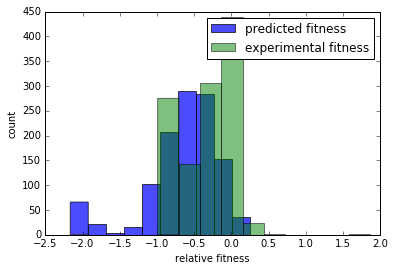

In [65]:
plt.hist(predictions[predictions > -1E10],alpha=0.7,label="predicted fitness"); #filter out -inf
plt.hist(np.array(target_values_singles)-1,alpha=0.5,label="experimental fitness");
plt.xlabel("relative fitness");
plt.ylabel("count")
plt.legend();

Mutual info: 0.999584277259


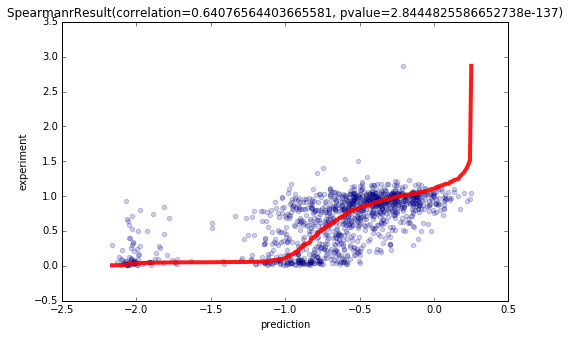

In [75]:
from sklearn.metrics.cluster import normalized_mutual_info_score
fig = plt.figure(figsize=(8,5))

x1=predictions

y1=target_values_singles[:len(predictions)]

plt.scatter(x1,y1,alpha=0.2)
plt.plot(sorted(x1),sorted(y1),"r",linewidth=4,alpha=0.9)
plt.title(str(spearmanr(x1,y1)))
plt.xlabel("prediction")
plt.ylabel("experiment")
print("Mutual info:", normalized_mutual_info_score(x1, y1))

He is a summary of the results in a table. 

In [76]:
size=len(predictions)
fitness_data=pd.DataFrame(columns=["lin","log","pred_wt","pred","pred_avg"])

fitness_data["experimental"]=exp_data_singles["linear"][:size]
fitness_data["effect_prediction_epistatic"]=exp_data_singles["effect_prediction_epistatic"][:size]
fitness_data["effect_prediction_independent"]=exp_data_singles['effect_prediction_independent'][:size]

fitness_data["prediction"]=fitnesses
fitness_data["prediction_wt"]=fitnesses_vs_wt
fitness_data["prediction_avg"]=fitnesses_vs_avg

corr_pred_singles=fitness_data.corr(method="spearman")
print("spearman rho correlations")
corr_pred_singles[["experimental"]]

spearman rho correlations


,experimental
experimental,1.000000
effect_prediction_epistatic,0.589337
effect_prediction_independent,0.423025
prediction,0.640766
prediction_wt,0.643795
prediction_avg,0.643541


### 4.2. Double mutants
We repeat the same analysis for double mutants. 

In [77]:
x_decoded=vae.predict(test_data_doubles_plus[0:sample_size],batch_size=batch_size)
digit_wt = x_decoded[0].reshape(digit_size,sequence_size)
digit_wt = normalize(digit_wt,axis=0, norm='l1')

mut_sample=100

digit_p= x_decoded[mut_sample].reshape(digit_size,sequence_size)
digit_p = normalize(digit_p,axis=0, norm='l1')

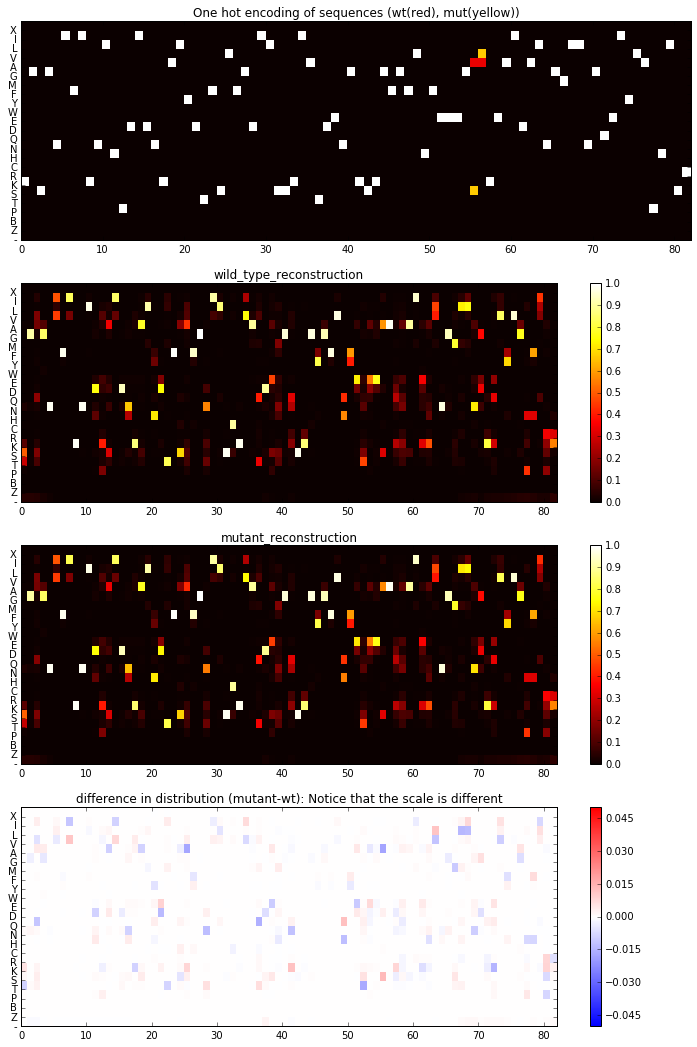

In [78]:
fig = plt.figure(figsize=(12,18))

fig.add_subplot(412)

plt.pcolor(digit_wt,cmap="hot",vmin=0,vmax=1)
plt.colorbar()

plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),AA_ORDER)
plt.title("wild_type_reconstruction")

fig.add_subplot(413)

plt.pcolor(digit_p,cmap="hot",vmin=0,vmax=1)
plt.colorbar()

plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),AA_ORDER)
plt.title("mutant_reconstruction")

fig.add_subplot(411)

plt.pcolor(abs(test_data_doubles_plus[0].reshape(digit_size,sequence_size)+(test_data_doubles_plus[mut_sample].reshape(digit_size,sequence_size))*2),cmap="hot",vmin=0,vmax=3)
plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),AA_ORDER)

plt.title("One hot encoding of sequences (wt(red), mut(yellow))")

fig.add_subplot(414)

plt.pcolor(-digit_wt+digit_p,cmap="bwr",vmin=-0.05,vmax=0.05)
plt.colorbar()
plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),AA_ORDER)

plt.title("difference in distribution (mutant-wt): Notice that the scale is different");

In [79]:
sample_size=batch_size*int(len(test_data_doubles_plus)/batch_size)
sample_for_averging_size=100
sequence_size = vae_data.get_seq_len()
digit_size = len(AA_ORDER)
x_decoded=vae.predict(test_data_doubles_plus[0:sample_size],batch_size=batch_size)

digit = x_decoded[0].reshape(digit_size,sequence_size)
digit_wt = normalize(digit,axis=0, norm='l1')
wt_prob=compute_log_probability(test_data_doubles_plus[0].reshape(digit_size,sequence_size),digit_wt)
print ("wt_log_prob: ", wt_prob)

wt_probs=[]
digit_avg=np.zeros((digit_size,sequence_size))


sample_indices=random.sample(range(sample_size),sample_for_averging_size)

counter=0
for sample in sample_indices:
    digit = x_decoded[sample].reshape(digit_size,sequence_size)
    digit_wt_i = normalize(digit,axis=0, norm='l1')
    
    digit_avg+=digit_wt_i*1./sample_for_averging_size
    wt_p=compute_log_probability(test_data_doubles_plus[sample].reshape(digit_size,sequence_size),digit_wt_i)
    wt_probs.append(wt_p)
    counter+=1
average_wt_p=np.mean(wt_probs)

fitnesses_vs_wt=[]
fitnesses=[]
fitnesses_vs_avg=[]

for sample in range(1,sample_size):
    digit = x_decoded[sample].reshape(digit_size,sequence_size)
    digit = normalize(digit,axis=0, norm='l1')
    fitness=compute_log_probability(test_data_doubles_plus[sample].reshape(digit_size,sequence_size),digit)-wt_prob
    fitnesses.append(fitness)
    
    fitness=compute_log_probability(test_data_doubles_plus[sample].reshape(digit_size,sequence_size),digit_wt)-wt_prob
    fitnesses_vs_wt.append(fitness)
    
    fitness=compute_log_probability(test_data_doubles_plus[sample].reshape(digit_size,sequence_size),digit_avg)-average_wt_p
    fitnesses_vs_avg.append(fitness)

wt_log_prob:  -68.7417426179


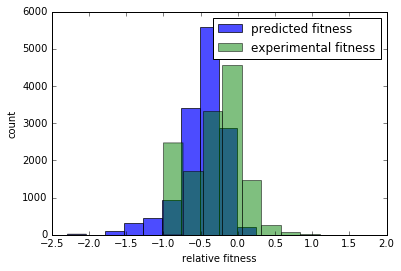

In [80]:
predictions=np.array(list(map(lambda x: x*1./(4*max (fitnesses)),fitnesses))) #arbitrary renormalization
indip=list(map(lambda x: x*1./max (exp_data_singles["effect_prediction_independent"]),exp_data_singles["effect_prediction_independent"]))
epis=list(map(lambda x: x*1./max (exp_data_singles["effect_prediction_epistatic"]),exp_data_singles["effect_prediction_epistatic"]))
plt.hist(predictions[predictions > -1E10],alpha=0.7,label="predicted fitness"); #filter out -inf
plt.hist(np.array(target_values_doubles)-1,alpha=0.5,label="experimental fitness");
plt.xlabel("relative fitness");
plt.ylabel("count")
plt.legend();

Mutual info: 0.978180523652


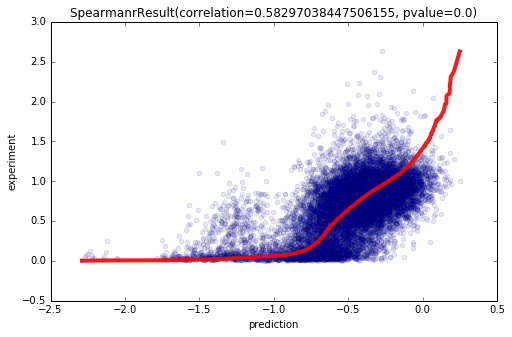

In [81]:
fig = plt.figure(figsize=(8,5))

x1=predictions
y1=target_values_doubles[:len(predictions)]

plt.scatter(x1,y1,alpha=0.1)
plt.plot(sorted(x1),sorted(y1),"r",linewidth=4,alpha=0.9)
plt.title(str(spearmanr(x1,y1)))
plt.xlabel("prediction")
plt.ylabel("experiment")
print("Mutual info:", normalized_mutual_info_score(x1,y1))